# Step #1 Initialize Spark Session

In [ ]:
# A tutorial for this file is available at www.relataly.com

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, isnan, when, count, udf, year, month, to_date, mean, explode
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Create my_spark
spark = SparkSession.builder.getOrCreate()
print(spark)

/home/admin123/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


# Step #2 Load the Weather Data

In [ ]:
# Read File A
spark_weather_dfs_a = spark.read \
    .option("header", False) \
    .option("sep", ",") \
    .option("inferSchema", True) \
    .csv(path=f'data/weather/zurich_weather_a')

spark_weather_dfs_a.printSchema()
spark_weather_dfs_a.describe().show()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: string (nullable = true)

+-------+------------------+----------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+----+
|summary|               _c0|       _c1|              _c2|               _c3|              _c4|              _c5|               _c6|               _c7|               _c8| _c9|
+-------+------------------+----------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+----+
|  count|             15384|     15384|            15363|             15384|            15243|              885|      

In [ ]:
# Read File B
spark_weather_df_b = spark.read \
    .option("header", False) \
    .option("inferSchema", True) \
    .csv(path=f'data/weather/zurich_weather_b')

spark_weather_df_b.printSchema()
spark_weather_df_b.describe().show()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)

+-------+------------------+----------+------------------+-----------------+
|summary|               _c0|       _c1|               _c2|              _c3|
+-------+------------------+----------+------------------+-----------------+
|  count|             15383|     15383|             15374|            15368|
|   mean|182.63121627770917|      null|13.705762976453755| 6.06695731389901|
| stddev|105.73420482794731|      null|  8.83091914731549|6.620985806040894|
|    min|                 0|1979-01-01|             -15.2|            -20.8|
|    max|               366|2021-01-01|              36.0|             22.5|
+-------+------------------+----------+------------------+-----------------+



# Step #3 Join the Data

In [ ]:
# Drop unused Columns
spark_weather_df_a = spark_weather_df_a.drop("_c0")
spark_weather_df_b = spark_weather_df_b.drop("_c0")

In [ ]:
# rename columns

# method A: rename individual columns
spark_weather_df_b_renamed = spark_weather_df_b.withColumnRenamed("_c1", "date") \
    .withColumnRenamed("_c2", "max_temp") \
    .withColumnRenamed("_c3", "min_temp")

# method B: rename multiple columns at once
def rename_multiple_columns(df, columns):
    if isinstance(columns, dict):
        return df.select(*[F.col(col_name).alias(columns.get(col_name, col_name)) for col_name in df.columns])
    else:
        raise ValueError("columns need to be in dict format {'existing_name_a':'new_name_a', 'existing_name_b':'new_name_b'}")

dict_columns = {"_c1": "date2",
                "_c2": "avg_temp",
                "_c3": "precip",
                "_c4": "snow",
                "_c5": "wind_dir",
                "_c6": "wind_speed",
                "_c7": "wind_power",
                "_c8": "air_pressure",
                "_c9": "sunny_hours",}
spark_weather_df_a_renamed = rename_multiple_columns(spark_weather_df_a , dict_columns)

In [ ]:
# Join the dataframes
spark_weather_df = spark_weather_df_a_renamed.join(spark_weather_df_b_renamed, spark_weather_df_a_renamed.date2 == spark_weather_df_b_renamed.date, "inner")

# Step #4 Gain a Quick Overview of the Data

In [ ]:
def quick_overview(dfs):
   # display the spark dataframe
   display("FIRST RECORDS")
   display(dfs.limit(2).sort(col("date"), ascending=True).toPandas())

   # count null values
   display("COUNT NULL VALUES")
   display(dfs.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c, y in df.dtypes if y in ["double", "float"]]
      ).toPandas())

   # print("DESCRIBE STATISTICS")
   # print(df.describe().toPandas())
   # # Alternatively to get the max value, we could use max_value = df.agg({"precipitation": "max"}).collect()[0][0]

   # check for dublicates
   dublicates = dfs.groupby(spark_weather_df.date) \
    .count() \
    .where('count > 1') \
    .limit(5).toPandas()
   display(dublicates)

   # print schema
   display("PRINT SCHEMA")
   display(dfs.printSchema())

quick_overview(spark_weather_df)

FIRST RECORDS
        date2  avg_temp  precip  snow  wind_dir  wind_speed  wind_power  \
0  2020-01-01      -1.8     0.0   0.0      63.0         4.2        14.8   
1  2020-01-01      -1.8     0.0   0.0      63.0         4.2        14.8   

   air_pressure sunny_hours        date  max_temp  min_temp  
0        1034.6        None  2020-01-01      -0.9      -2.9  
1        1034.6        None  2020-01-01      -0.9      -2.9  
COUNT NULL VALUES
   avg_temp  precip  snow  wind_dir  wind_speed  wind_power  air_pressure  \
0        21       0   143     14577       14565       14565         14565   

   max_temp  min_temp  
0         9        15  
         date  count
0  1986-01-01      4
1  2011-01-01      4
2  2005-01-01      4
3  1985-01-01      4
4  2006-01-01      4
PRINT SCHEMA
root
 |-- date2: string (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- wind_dir: double (nullable = true)
 |-- wind_speed: d

# Step #5 Clean the Data

In [ ]:
# filter Null values
spark_weather_df = spark_weather_df.filter(spark_weather_df.avg_temp.isNotNull())

In [ ]:
# replace na values with mean values
avg = spark_weather_df.filter(spark_weather_df.avg_temp.isNotNull())\
    .select(mean(col('min_temp')).alias('mean_min'),
            mean(col('max_temp')).alias('mean_max'),
            mean(col('wind_speed')).alias('mean_wind')).collect()

mean_min = avg[0]['mean_min']
mean_max = avg[0]['mean_max']
mean_wind = avg[0]['mean_wind']

spark_weather_df = spark_weather_df \
    .na.fill(value=mean_min, subset=["min_temp"]) \
    .na.fill(value=mean_max, subset=["max_temp"]) \
    .na.fill(value=mean_wind, subset=["wind_speed"]) \
    .na.fill(value=0, subset=["snow"])

In [ ]:
# check for dublicates
spark_weather_df.groupby(spark_weather_df.date) \
    .count() \
    .where('count > 1') \
    .limit(5).toPandas()

date  count
0  1986-01-01      4
1  2011-01-01      4
2  2005-01-01      4
3  1985-01-01      4
4  2006-01-01      4

In [2]:
# remove dublicates and drop column date2, convert date to datatype "date", Sort the Data by Date
# drop date2 column, convert date column from string to date type, order by date
spark_cleaned_df = spark_weather_df.dropDuplicates()\
    .drop(col("date2"))\
    .withColumn("date", to_date(col("date"),"yyyy-MM-dd")) \
    .orderBy(col("date")) \
    .select(col("date"),col("avg_temp"),col("min_temp"),col("max_temp"),col("wind_speed"),col("snow"),col("precip")) # select columns

quick_overview(spark_cleaned_df)

'spark_cleaned_df = spark_weather_df.dropDuplicates()    .drop(col("date2"))    .withColumn("date", to_date(col("date"),"yyyy-MM-dd"))     .orderBy(col("date"))     .select(col("date"),col("avg_temp"),col("min_temp"),col("max_temp"),col("wind_speed"),col("snow"),col("precip")) # select columns\n\nquick_overview(spark_cleaned_df)'

# Step #6 Transform the Data using User Defined Functions (UDF)

In [ ]:
# More Infos on User Defined Functions: https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
# create bucket column for temperature
def binner(min_temp, max_temp):
        if (min_temp is None) or (max_temp is None):
            return "unknown"
        else:
            if min_temp < -10:
                return "freezing cold"
            elif min_temp < -5:
                return "very cold"
            elif min_temp < 0:
                return "cold"
            elif max_temp < 10:
                return "normal"
            elif max_temp < 20:
                return "warm"
            elif max_temp < 30:
                return "hot"
            elif max_temp >= 30:
                return "very hot"
        return "normal"


udf_binner_temp = udf(binner, StringType() )

spark_cleaned_df = spark_cleaned_df.withColumn("temp_buckets", udf_binner_temp(col("min_temp"), col("max_temp")))
spark_cleaned_df.limit(10).toPandas()

date  avg_temp  min_temp  max_temp  wind_speed   snow  precip  \
0  1979-01-01      -5.3     -12.2      -2.5    7.326082    0.0     1.0   
1  1979-01-02     -10.0     -12.2      -4.2    7.326082   10.0     1.7   
2  1979-01-03      -5.8      -7.9      -3.9    7.326082  110.0     0.0   
3  1979-01-04      -8.4     -10.5      -4.4    7.326082  100.0     0.0   
4  1979-01-05     -10.0     -11.2      -7.5    7.326082   70.0     0.0   
5  1979-01-06      -6.4     -10.1      -2.8    7.326082   50.0     0.0   
6  1979-01-07      -3.8      -5.1      -2.9    7.326082   40.0     0.0   
7  1979-01-08      -2.4      -4.5       1.4    7.326082   40.0     5.1   
8  1979-01-09       1.4      -0.4       3.8    7.326082   20.0     3.2   
9  1979-01-10       0.4      -1.4       2.8    7.326082   10.0     5.4   

    temp_buckets  
0  freezing cold  
1  freezing cold  
2      very cold  
3  freezing cold  
4  freezing cold  
5  freezing cold  
6      very cold  
7           cold  
8           cold  
9           cold

In [ ]:
# create new columns for bucket percipitation and for month and year
udf_binner_precip = udf(lambda x: "very rainy" if x > 50 else ("rainy" if x > 0 else "dry"), StringType())
spark_cleaned_df = spark_cleaned_df \
    .withColumn("precip_buckets", udf_binner_precip("precip")) \
    .withColumn("month", month(spark_cleaned_df.date)) \
    .withColumn("year", year(spark_cleaned_df.date))
spark_cleaned_df.limit(5).toPandas()

date  avg_temp  min_temp  max_temp  wind_speed   snow  precip  \
0  1979-01-01      -5.3     -12.2      -2.5    7.326082    0.0     1.0   
1  1979-01-02     -10.0     -12.2      -4.2    7.326082   10.0     1.7   
2  1979-01-03      -5.8      -7.9      -3.9    7.326082  110.0     0.0   
3  1979-01-04      -8.4     -10.5      -4.4    7.326082  100.0     0.0   
4  1979-01-05     -10.0     -11.2      -7.5    7.326082   70.0     0.0   

    temp_buckets precip_buckets  month  year  
0  freezing cold          rainy      1  1979  
1  freezing cold          rainy      1  1979  
2      very cold            dry      1  1979  
3  freezing cold            dry      1  1979  
4  freezing cold            dry      1  1979

# Step #7 Data Analysis

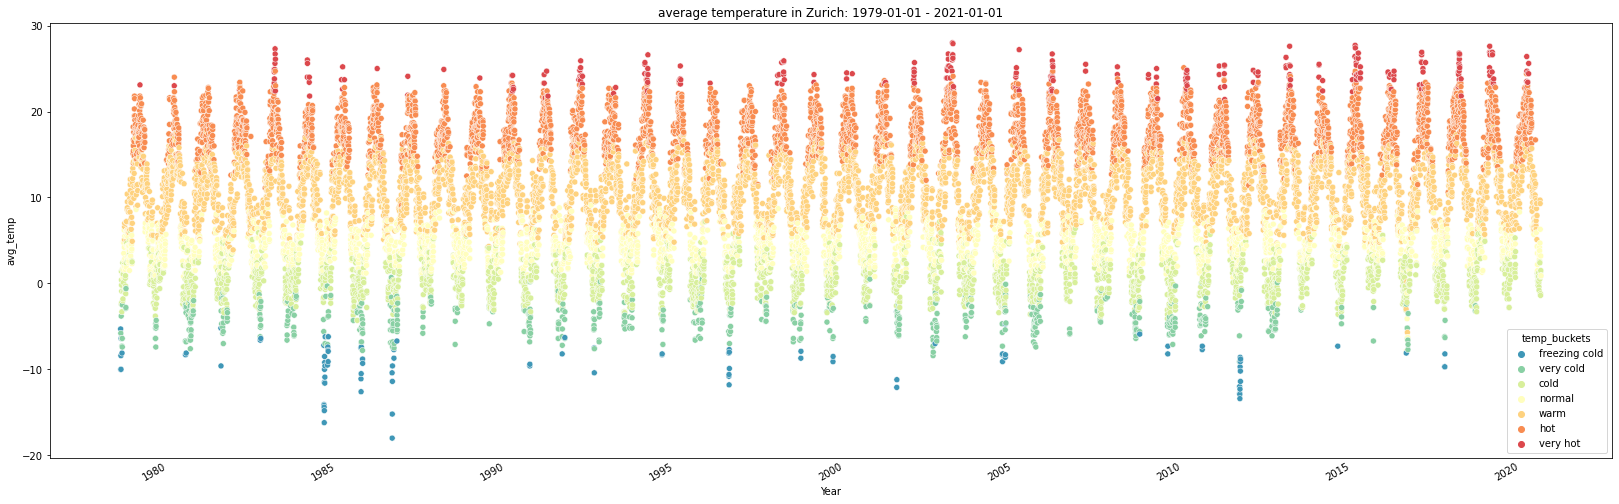

In [ ]:
# set the dimensions for the scatterplot
fig, ax = plt.subplots(figsize=(28,8))
sns.scatterplot(hue="temp_buckets", y="avg_temp", x="date", data=spark_cleaned_df.toPandas(), palette="Spectral_r")

# plot formatting
ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)

# title formatting
mindate = str(spark_cleaned_df.agg({'date': 'min'}).collect()[0]['min(date)'])
maxdate = str(spark_cleaned_df.agg({'date': 'max'}).collect()[0]['max(date)'])
ax.set_title("average temperature in Zurich: " + mindate + " - " + maxdate)
plt.xlabel("Year")
plt.show()

<AxesSubplot:xlabel='year', ylabel='month'>

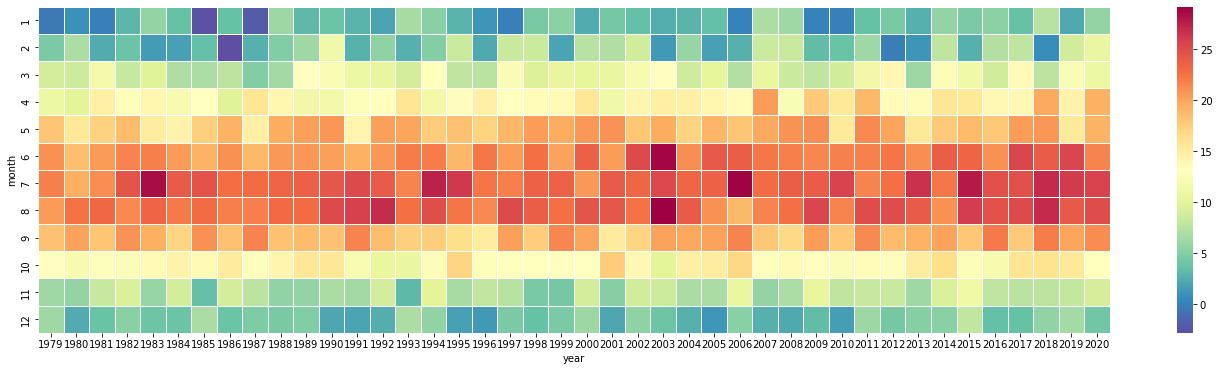

In [ ]:
spark_cleaned_df_agg = spark_cleaned_df.select(col("year"),col("month"),col("max_temp")) \
    .filter(spark_cleaned_df.year < 2021)\
    .groupby(col("year"),col("month"))\
    .agg(mean("max_temp").alias("mean_max_temp")) \
    .orderBy(col("year")).toPandas()

plt.figure(figsize=(24,6))
avg_temp_df = spark_cleaned_df_agg.pivot("month", "year", "mean_max_temp")
sns.heatmap(avg_temp_df, cmap="Spectral_r", linewidths=.5)

# Step #7.2 SQL PySpark

   year  month  mean(avg_temp)  mean(max_temp)  mean(min_temp)
0  1979      5       19.180000       26.940000       12.900000
1  1979      6       19.200000       25.842857       14.385714
2  1979      7       20.828571       27.071429       15.357143
3  1979      8       20.200000       27.000000       14.216667
4  1979      9       19.000000       25.400000       13.700000


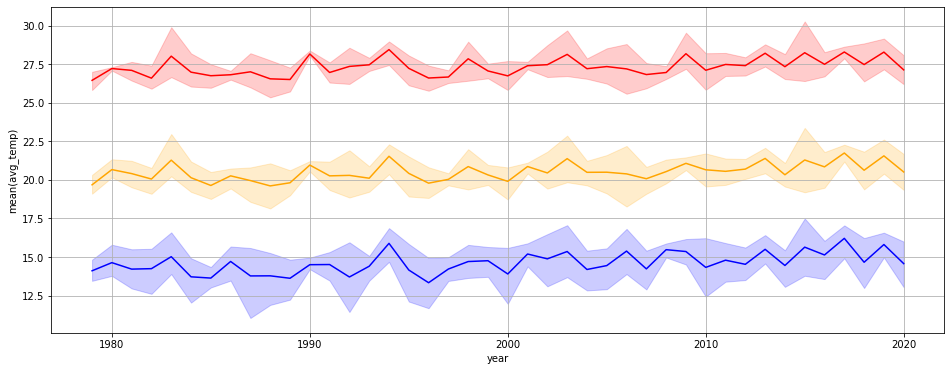

In [ ]:
# Using PySpark standard functions
# events_over_years_df = spark_cleaned_df\
#     .filter(spark_cleaned_df.year < 2021)\
#     .groupby(col("year"))\
#     .agg(mean("avg_temp").alias("mean_avg_temp"),
#          mean("min_temp").alias("mean_min_temp"),
#          mean("max_temp").alias("mean_max_temp"))\
#     .orderBy(col("year")).toPandas()

# plt.figure(figsize=(15,6))


# Data Analysis using PySpark.SQL

# register the dataset as a temp view, so we can use sq
spark_cleaned_df.createOrReplaceTempView("waeather_data_temp_view")

# see how event numbers have evolved over years
events_over_years_df = spark.sql( \
        'SELECT year, month, mean(avg_temp), mean(max_temp), mean(min_temp) \
        FROM waeather_data_temp_view \
        WHERE max_temp > 25 \
        GROUP BY month, year \
        ORDER BY year, month')
print(events_over_years_df.limit(5).toPandas())

plt.figure(figsize=(16,6))
fig = sns.lineplot(y="mean(avg_temp)", x="year", data=events_over_years_df.toPandas(), color= "orange")
fig = sns.lineplot(y="mean(max_temp)", x="year", data=events_over_years_df.toPandas(), color= "red")
fig = sns.lineplot(y="mean(min_temp)", x="year", data=events_over_years_df.toPandas(), color= "blue")
plt.grid()
plt.show()


# Step 7.3 Scatter Plots

Text(0.5, 1.0, 'min - max temperature seperated by month')

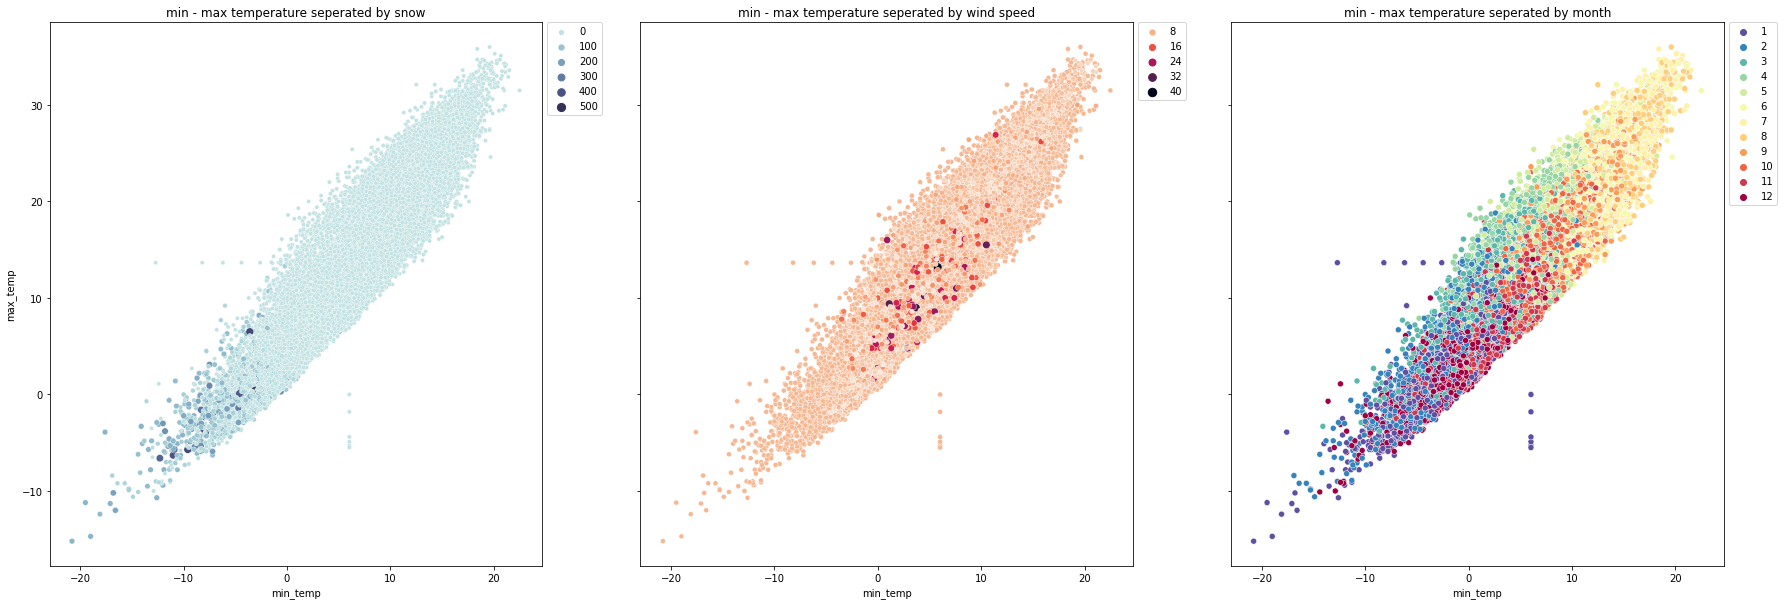

In [ ]:
fig, axes= plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(30, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.scatterplot(ax = axes[0], hue="snow", size="snow", y="max_temp", x="min_temp", data=spark_cleaned_df.toPandas(), alpha=1.0, palette=palette)
axes[0].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[0].set_title("min - max temperature seperated by snow")

sns.scatterplot(ax = axes[1], hue="wind_speed", size="wind_speed", y="max_temp", x="min_temp", data=spark_cleaned_df.toPandas(), alpha=1.0, palette='rocket_r')
axes[1].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[1].set_title("min - max temperature seperated by wind speed")

sns.scatterplot(ax = axes[2], hue="month", y="max_temp", x="min_temp", data=spark_cleaned_df.toPandas(), alpha=1.0, palette='Spectral_r', hue_norm=(1,12), legend="full")
axes[2].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[2].set_title("min - max temperature seperated by month")
